# Bibliotecas

In [176]:
#import statsmodels.api as sm
import statsmodels.tsa.api as tsa
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
#import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

#mpl.rcParams['figure.figsize'] = [10, 5]


In [2]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_dehli.csv")

In [3]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)


C:\Users\lucas\AppData\Local\Temp/ipykernel_6492/1178737778.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('date', 1)


In [4]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [5]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

#### Funções de apoio

In [ ]:
def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    print('mape', mean_absolute_percentage_error(prediction, y_test))
    results[name] = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test),
                    'mape': mean_absolute_percentage_error(prediction, y_test)}

def graf_ajuste(pred, train, titulo):
    #Previsão do treino
    fig, ax = plt.subplots()
    ax.plot(pred, label='pred')
    ax.plot(train, label='true')
    plt.title(titulo)
    plt.legend()

def graf_pred(fitted, train, test, titulo, SVR=False):
    
    if(SVR==True):
        fc = fitted
        fc_series = pd.Series(fc, index=test.index[1:])
    else:
        fc = fitted.forecast(394, alpha=0.05)  # 95% conf
        fc_series = pd.Series(fc, index=test.index)

    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(fc_series, label='Predição')
    plt.title(titulo)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Plot

<AxesSubplot:xlabel='date'>

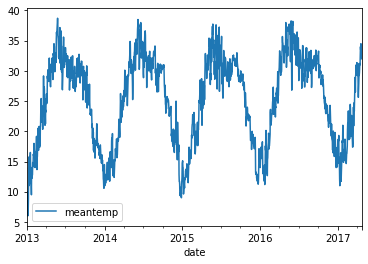

In [6]:
df.plot()

## Decomposição

Através da decomposição verificamos que há tendência... portanto a série não deve ser estacionária, vamos verificar a seguir.

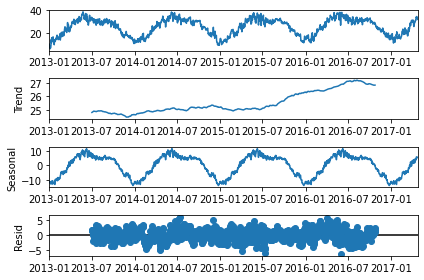

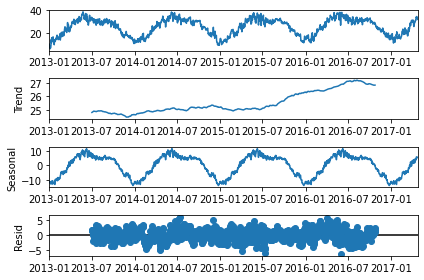

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Estacionariedade

Como a função de auto correlação abaixo não decai  para zero, suspeitamos de que a série não seja estacionária. Vamos verificar a seguir por meio de um teste de hipóteses.

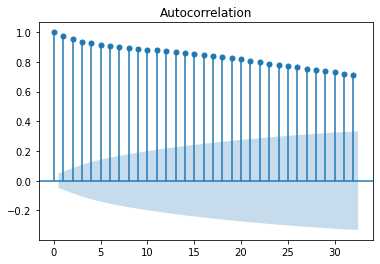

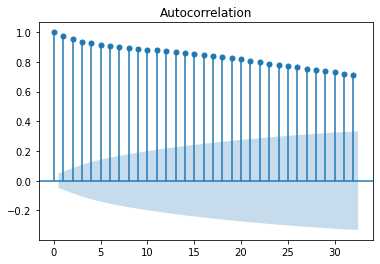

In [8]:
plot_acf(df)

Considerando um nível de confiança de 0,05 verificamos que o teste de Dickey-Fuller nos leva a não rejeitar a hipótese nula de não estacionariedade, visto que o p-valor = 0,149 (>0,05). Portanto, temos evidências para acreditar que a série não é estacionária.

In [9]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df)
print(pvalue)
print(lags)

0.14882501558674888
10


## Diferenciação

<AxesSubplot:xlabel='date'>

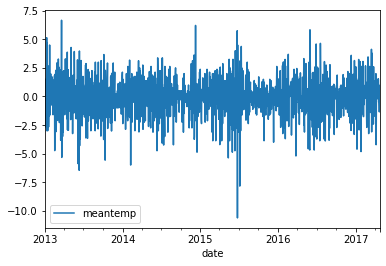

In [10]:
df.diff().plot()

Após diferenciar a série aparenta ser estacionária, vamos verificar com o teste de Dickey-Fuller.

<AxesSubplot:ylabel='Frequency'>

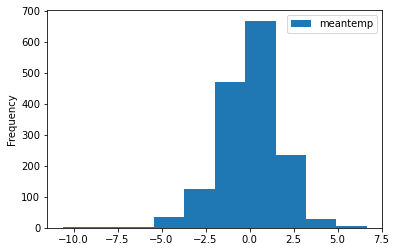

In [11]:
df.diff().plot.hist()

In [12]:
dfd1 = df.diff().dropna()

Como o p-valor<0,05 então decidimos rejeitar a hipótese nula de não estacionariedade à um nível de confiança de 0,05. Portanto, após diferenciar uma vez a série temos evidências para acreditar que a série se tornou estacionária.

In [13]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1)
print(pvalue)
print(lags)

9.593523131253509e-30
9


## Autocorrelação

### Correlação

In [14]:
df.corrwith(df.shift(1))

meantemp    0.974134
dtype: float64

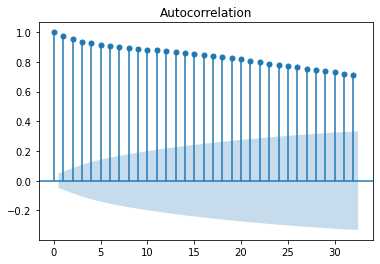

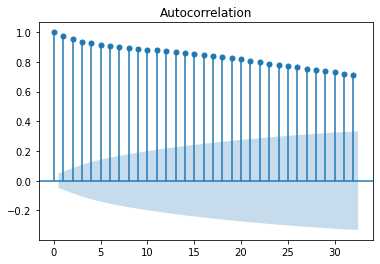

In [15]:
plot_acf(df)

Correlação com série diferenciada

In [16]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

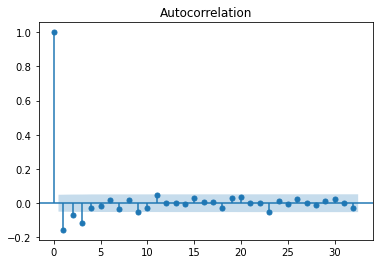

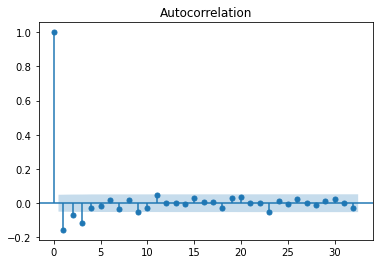

In [17]:
plot_acf(dfd1)

## Autocorrelação Parcial

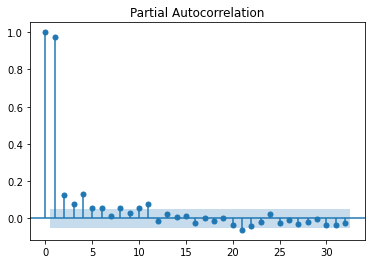

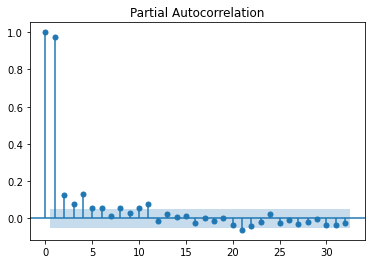

In [18]:
plot_pacf(df)

Correlação Parcial com série diferenciada

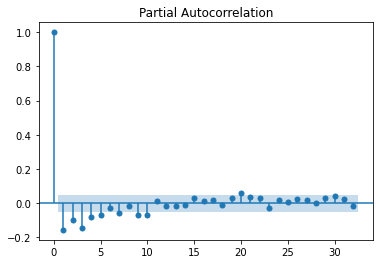

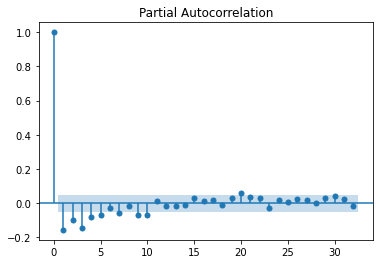

In [19]:
plot_pacf(dfd1)

### ARIMA

In [ ]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_train.head()

In [120]:
def perform_arima(p,d,q,data):
    arima_model = ARIMA(data, order=(p,d,q))
    res_arima = arima_model.fit()
    print(res_arima.summary())
    res_arima.plot_diagnostics()
    return res_arima


ARIMA (5,1,3)

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2232.011
Date:                Wed, 13 Apr 2022   AIC                           4482.022
Time:                        10:23:17   BIC                           4527.682
Sample:                    01-01-2013   HQIC                          4499.236
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1960      0.071      2.774      0.006       0.058       0.335
ar.L2         -0.7646      0.051    -14.847      0.000      -0.866      -0.664
ar.L3          0.4747      0.095      4.989      0.0

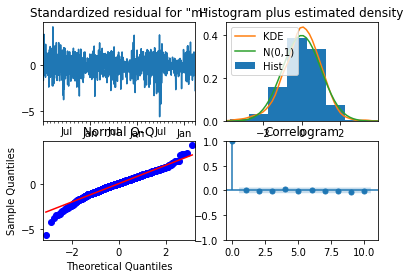

In [122]:
res_arima_1 = perform_arima(5,1,3,df_train)

ARIMA (4,1,3)

In [ ]:
res_arima_2 = perform_arima(4,1,3,df_train)

Plotando o ajuste do modelo aos dados de treino

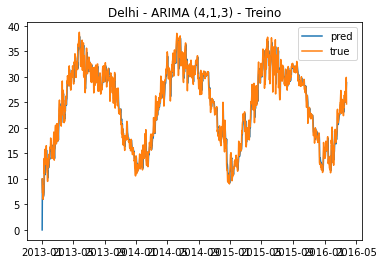

In [101]:
graf_ajuste(res_arima_2.predict(), df_train, 'Delhi - ARIMA (4,1,3) - Treino')

Plotando Treino, teste e a predição do modelo

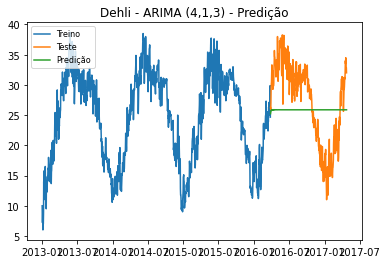

In [105]:
graf_pred(res_arima_2, df_train, df_test, 'Dehli - ARIMA (4,1,3) - Predição')

In [27]:
results = {}

In [28]:
forecast = res_arima_2.forecast(394, alpha=0.05)
show_metrics(df_test, forecast, results, 'ARIMA(4,1,3)')

ARIMA(4,1,3) - model Results
r2 -29244.06420696393
mse 48.09442893779906
mae 6.238789808283262
mape 0.2410864250599167


ARIMA (0,1,3)

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2236.505
Date:                Wed, 13 Apr 2022   AIC                           4481.009
Time:                        10:26:09   BIC                           4501.302
Sample:                    01-01-2013   HQIC                          4488.660
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2199      0.025     -8.970      0.000      -0.268      -0.172
ma.L2         -0.1197      0.025     -4.704      0.000      -0.170      -0.070
ma.L3         -0.1432      0.030     -4.837      0.0

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


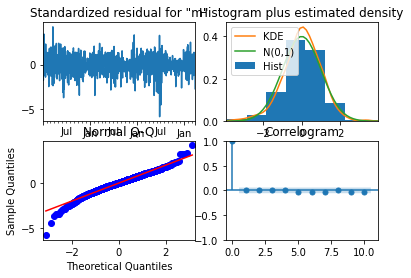

In [130]:
res_arima_3 = perform_arima(0,1,3,df_train)

### Auto ARIMA

In [29]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4494.045, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9511.186, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4512.618, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4531.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4493.975, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, 

In [30]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Wed, 13 Apr 2022   AIC                           4489.732
Time:                        09:14:57   BIC                           4515.102
Sample:                             0   HQIC                          4499.296
                               - 1181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009       0.110
ar.L1          1.5616      0.055     28.192      0.000       1.453       1.670
ar.L2         -0.5638      0.055    -10.282      0.000      -0.671      -0.456
ma.L1         -0.7881      0.045    -17.488      0.000      -0.876      -0.700
sigma2         2.5920      0.086     30.135      0.000       2.423       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.00
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.46
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


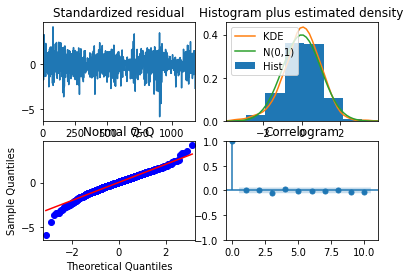

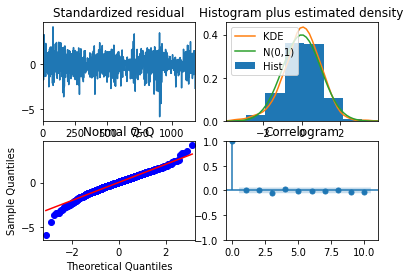

In [31]:
auto_arima.plot_diagnostics()

Plotando ajuste do modelo aos dados de treino

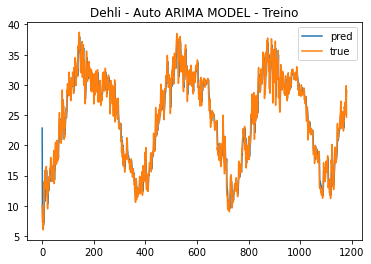

In [107]:
graf_ajuste(auto_arima.predict_in_sample(), df_train.values, 'Dehli - Auto ARIMA(2,0,1) - Treino')

Plotando Treino, teste e predição

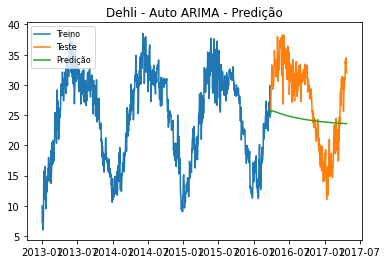

In [108]:
model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  
graf_pred(fitted, df_train, df_test, 'Dehli - Auto ARIMA(2,0,1) - Predição')

In [34]:
forecast = auto_arima.predict(n_periods=394)
show_metrics(df_test, forecast, results, 'Auto ARIMA(2,0,1)')

ARIMA(2,0,1) - model Results
r2 -95.85896516856229
mse 49.68913135264666
mae 6.356182978044135
mape 0.2623335314335786


## Machine Learning

### Feature Engineering

In [169]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [170]:
X = get_lags(df, 5)
X.head()

,meantemp-1,meantemp-2,meantemp-3,meantemp-4,meantemp-5
date,,,,,
2013-01-06,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-07,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-08,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-09,8.857143,7.000000,7.000000,6.000000,8.666667
2013-01-10,14.000000,8.857143,7.000000,7.000000,6.000000


In [171]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143
2013-01-09,14.000000
2013-01-10,11.000000


In [172]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizaremos o GridSearch para encontrar os melhores parâmetros para o KNN.

In [113]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

('n_neighbors', range(1, 20))
('weights', ['uniform', 'distance'])


In [114]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, cv=TimeSeriesSplit(n_splits=10))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

0.675376613341037
{'n_neighbors': 4, 'weights': 'uniform'}


Métricas

In [115]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

KNN GS - model Results
r2 0.9238904124738847
mse 3.1078862581793802
mae 1.368122745151274
mape 0.05838498835397461


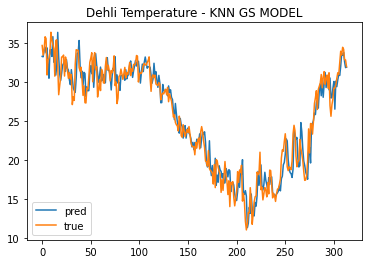

In [117]:
graf_ajuste(prediction, y_test.reset_index(drop=True), 'Dehli Temperature - KNN GS MODEL')


<AxesSubplot:>

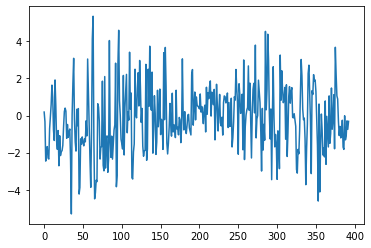

In [46]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

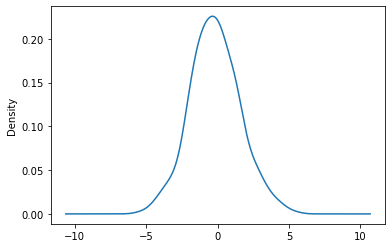

In [47]:
pd.Series(residuos).plot.kde()

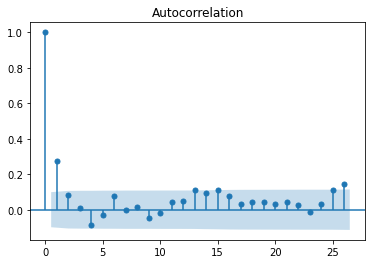

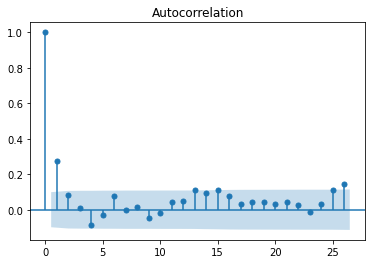

In [48]:
plot_acf(residuos)

KNN com série difenciada

In [123]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [124]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

-0.003559516392591422
{'n_neighbors': 19, 'weights': 'uniform'}


In [125]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

d1 KNN GS - model Results
r2 -15.60173661565397
mse 2.6030433413692746
mae 1.2354485784319826
mape 11.727716862438847


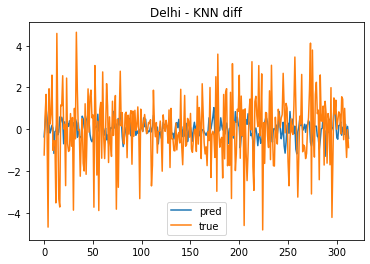

In [126]:
graf_ajuste(pd.Series(prediction_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - KNN diff')

One step ahead

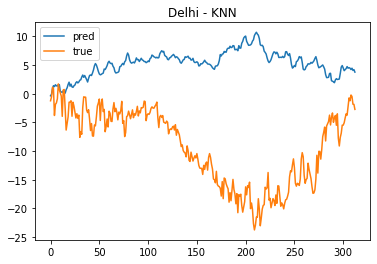

In [128]:
graf_ajuste(pd.Series(prediction_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - KNN')

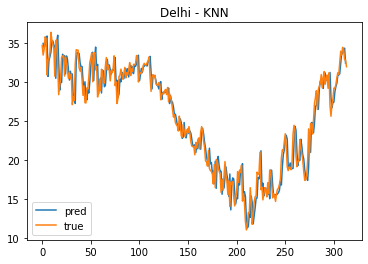

In [131]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [56]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

pred one KNN GS - model Results
r2 0.9325385055689803
mse 3.1470734417768313
mae 1.3138804267176756
mape 0.05348903321925905


In [57]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

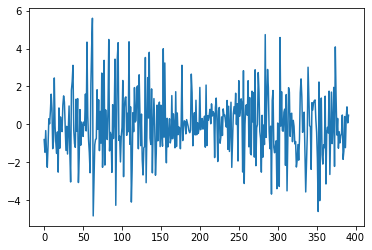

In [58]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

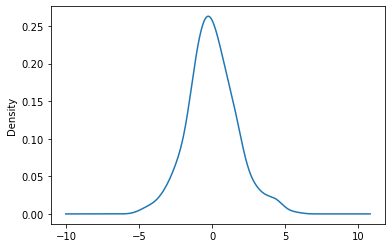

In [59]:
pd.Series(residuos).plot.kde()

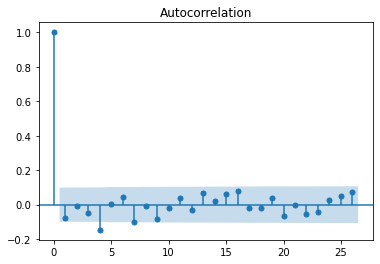

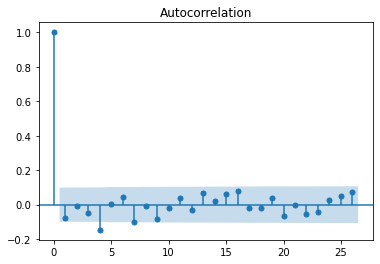

In [60]:
plot_acf(residuos)

### Support Vector Regression

In [132]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(epsilon=0.2, kernel='linear')

In [133]:
mean_absolute_error(regr.predict(X_test), y_test)

1.2056236463758845

In [134]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR')

SVR - model Results
r2 0.9403508195887784
mse 2.5043252466442603
mae 1.2056236463758845
mape 0.05149918344873464


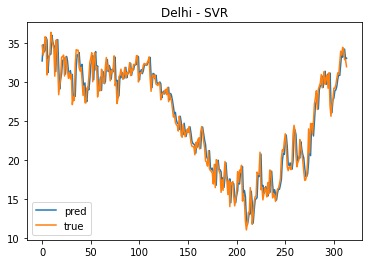

In [153]:
graf_ajuste(regr.predict(X_test), y_test.reset_index(drop=True), 'Delhi - SVR')

In [159]:
len(regr.predict(X_test))

314

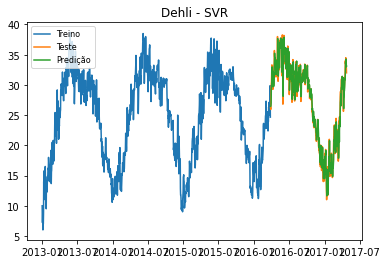

In [177]:
graf_pred(regr.predict(X_test), df_train, df_test, 'Dehli - SVR', SVR=True)

#### Grid Search (TODO: testar outros parametros) 

In [178]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [179]:
#parameters = {'kernel':['linear','rbf'], 'C':[0.1,1,10]}
parameters = {'kernel':['linear','rbf', 'sigmoid', 'polynomial'], 
              #'C':range(0.05, 50, 20),
              'C':np.linspace(0.05, 10, 30),
              #'gamma':np.linspace(.1, 10, 3),
              #'coef0':np.linspace(.01, 10, 3),
              #'degree':np.arange(2, 3)
              }

for p in parameters.items():
  print(p)

('kernel', ['linear', 'rbf', 'sigmoid', 'polynomial'])
('C', array([ 0.05, 10.  ]))


In [180]:
regr2 = SVR()
regrGS = GridSearchCV(regr2, parameters, cv=TimeSeriesSplit())

In [181]:
#%%time
res = regrGS.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

In [182]:
print(res.best_score_)
print(res.best_params_)
#'C': 0.1, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'
#12 minutos


#'C': 7.788888888888888, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
#5 minutos

0.9232604275216791
{'C': 10.0, 'kernel': 'linear'}


In [183]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GS')

SVR GS - model Results
r2 0.94230983823026
mse 2.6226386947474363
mae 1.2367683966451415
mape 0.04934696314581894


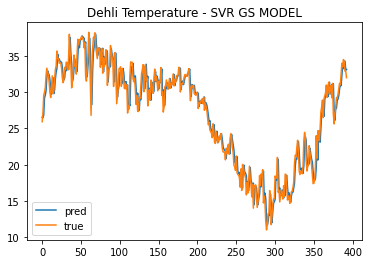

In [184]:
graf_ajuste(res.predict(X_test), y_test.reset_index(drop=True), 'Dehli Temperature - SVR GS MODEL')

In [ ]:
pd.DataFrame(results)

Usando get_lags

In [185]:
X = get_lags(df, 5)
y = df.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

In [186]:
regr_GL = SVR(kernel='linear')
regr_GL.fit(X_train, y_train)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(kernel='linear')

In [187]:
forecast = regr_GL.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GL')

SVR GL - model Results
r2 0.9403183104730123
mse 2.5129607027733925
mae 1.2070850477651554
mape 0.05155140833455998


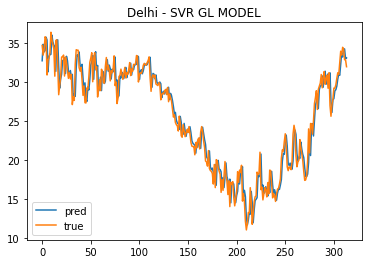

In [188]:
graf_ajuste(regr_GL.predict(X_test), y_test.reset_index(drop=True), 'Delhi - SVR GL MODEL')

In [ ]:
pd.DataFrame(results)

Verificando Overfitting

In [93]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

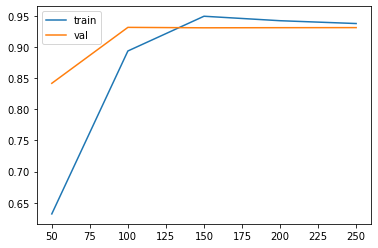

In [94]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

### MLP (TODO: testar arquiteturas e tuning)

In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

#### Divisão de Dados MLP 

In [62]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=.25)

#### Diferenciação

In [63]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

In [64]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

<AxesSubplot:xlabel='date'>

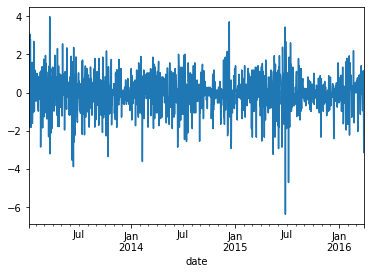

In [65]:
X_train_d1_norm['meantemp-1'].plot()

<AxesSubplot:title={'center':'train'}, ylabel='Frequency'>

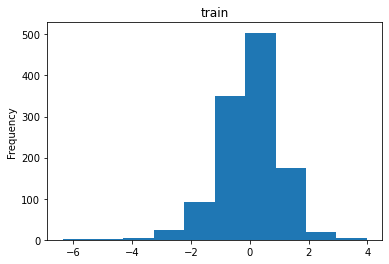

In [66]:
X_train_d1_norm['meantemp-1'].plot.hist(title='train')

<AxesSubplot:title={'center':'validation'}, ylabel='Frequency'>

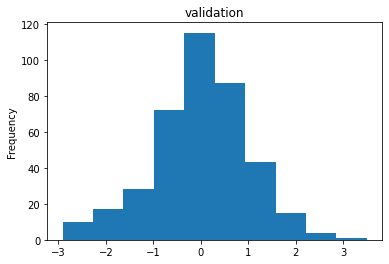

In [67]:
X_valid_d1_norm['meantemp-1'].plot.hist(title='validation')

<AxesSubplot:title={'center':'test'}, ylabel='Frequency'>

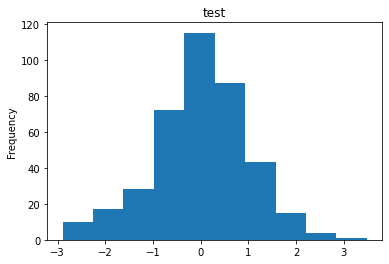

In [68]:
X_test_d1_norm['meantemp-1'].plot.hist(title='test')


#### Batches

In [69]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)


In [70]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

In [71]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Config 1
    # self.fc1 = nn.Linear(5,100)
    # self.fc3 = nn.Linear(100,1)
    
    #Config 2
    # self.fc1 = nn.Linear(5,32)
    # self.fc2 = nn.Linear(32,64)
    # self.fc3 = nn.Linear(64,1)
     
    # #Config 3
    self.fc1 = nn.Linear(5,32)
    self.drop1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(32,64)
    self.drop2 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(64,1)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    out = self.drop1(out)
    out = torch.relu(self.fc2(out))
    out = self.drop2(out)
    out = self.fc3(out)
    return out

In [72]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([-0.1700], grad_fn=<AddBackward0>)
meantemp    0.0
Name: 2013-01-07 00:00:00, dtype: float64


In [73]:
multi_neuron = MLP()
epochs = 300
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

C:\Users\lucas\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lucas\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lucas\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

Epoch10, train loss 2.8012741989380605
Epoch10, valid loss 2.722304494380951
Epoch20, train loss 2.8011877790496156
Epoch20, valid loss 2.722521810531616
Epoch30, train loss 2.801147237420082
Epoch30, valid loss 2.7226276850700377
Epoch40, train loss 2.8011277857664467
Epoch40, valid loss 2.722675049304962
Epoch50, train loss 2.8011175096035004
Epoch50, valid loss 2.722688796520233
Epoch60, train loss 2.8011131943077654
Epoch60, valid loss 2.7226889443397524
Epoch70, train loss 2.801113208000724
Epoch70, valid loss 2.7226848101615904
Epoch80, train loss 2.8011149727814906
Epoch80, valid loss 2.7226830387115477
Epoch90, train loss 2.801119312644005
Epoch90, valid loss 2.722676064968109
Epoch100, train loss 2.80112563556916
Epoch100, valid loss 2.7226651334762573
Epoch110, train loss 2.801133640714594
Epoch110, valid loss 2.722653841972351
Epoch120, train loss 2.8011429801180556
Epoch120, valid loss 2.7226414394378664
Epoch130, train loss 2.8011527210474014
Epoch130, valid loss 2.7226288

<AxesSubplot:>

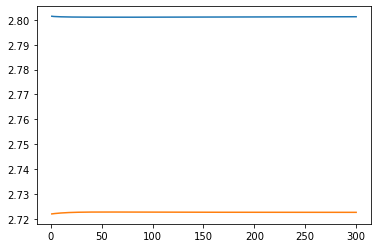

In [95]:
history_train = {}
history_valid = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  loss_valid = 0.0
  for valid_data in valid_dataloader:    
    x = valid_data[:,:5].float()
    y = valid_data[:,5].float()   
    #forward pass
    target = multi_neuron(x)
    #loss measure
    loss = loss_fn(outputs,y)
    # Calculate Loss
    loss_valid += loss.item()


  if (epoch % 10 == 0):
    print('Epoch{}, train loss {}'.format(epoch, loss_train / len(train_dataloader)))
    print('Epoch{}, valid loss {}'.format(epoch, loss_valid / len(valid_dataloader))) # apresenta o erro médio da época
  history_train[epoch] = loss_train / len(train_dataloader)
  history_valid[epoch] = loss_valid / len(valid_dataloader)

pd.Series(history_train).plot()
pd.Series(history_valid).plot()

#pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
#pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
#plt.legend()

<AxesSubplot:>

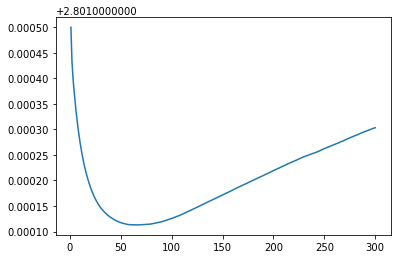

In [96]:
pd.Series(history_train).plot()

In [75]:
multi_neuron.eval()
results_MLP = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = multi_neuron(x)
    results_MLP.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results_MLP[:10]

[0.0031103566,
 -0.014831209,
 0.030051446,
 0.09183656,
 0.07829938,
 0.11266496,
 0.10260462,
 0.053114668,
 0.029787945,
 -0.006897622]

<AxesSubplot:>

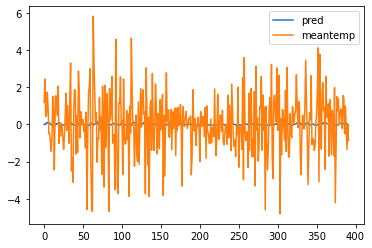

In [76]:
pd.concat([pd.Series(results_MLP, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [102]:
show_metrics(y_test_d1,results_MLP, results, 'MLP')

MLP - model Results
r2 -1569.3261432280706
mse 2.7862235572457448
mae 1.2684934733570306
mape 119.75996566821881


In [106]:
pd.DataFrame(results)

,"ARIMA(4,1,3)","ARIMA(2,0,1)",KNN GS,d1 KNN GS,pred one KNN GS,MLP,SVR,SVR GL
r2,-29244.064207,-95.858965,0.925178,-14.670800,0.932539,-1569.326143,0.942085,0.940318
mse,48.094429,49.689131,3.085160,2.733423,3.147073,2.786224,2.633567,2.512961
mae,6.238790,6.356183,1.388425,1.265981,1.313880,1.268493,1.238467,1.207085
mape,0.241086,0.262334,0.054734,45.833711,0.053489,119.759966,0.049396,0.051551


Dúvidas

- Pela metodologia Box and Jekings podemos usar o AUTO ARIMA ou devemos testar na mão diferentes ARIMAS?